<a href="https://colab.research.google.com/github/dniggl/Insights/blob/main/Web_Scraping_TripAdviser_Reviews2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Scrape hotel reviews webpages, extract some data and perform sentiment analysis. 

**Install the Packages** 

In [ ]:
# Install the packages.
!pip install selenium 

**Import the Libraries** 

In [ ]:
# Import the libraries.
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import csv

Define the TripAdvisor URL. 

In [ ]:
# Define the Tripadvisor URL
url = "https://www.tripadvisor.com/Hotel_Review-g60634-d114075-Reviews-or80-Sheraton_Maui_Resort_Spa-Lahaina_Maui_Hawaii.html"

**Install the Web Driver**

In [ ]:
# Install the chrome web driver from selenium. 
!apt-get update 
!apt install chromium-chromedriver

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

The web driver is a key component of selenium. The web driver is a browser automation framework that works with open source APIs. The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.

Selenium supports multiple web browsers and offers web drivers for each browser. I have imported the chrome web driver from selenium. Alternatively, you can download the web driver for your specific browser and store it in a location where it can be easily accessed (C:\users\webdriver\chromedriver.exe). You can download a web driver for your browser at this site https://selenium-python.readthedocs.io/installation.html#:~:text=Selenium%20requires%20a-,driver,-to%20interface%20with  

**Find and Extract the Data Elements**

The get command launches the browser and opens the specified URL in your web driver.

In [ ]:
driver.get(url)

For each of the data elements we want to extract, we will find all the HTML lines that are within a specific tag and class. We will then extract the data elements and store the data in a list. For this project we will scrape 10 consecutive webpages.

In [ ]:
name_list = []
titles_list = [] 
reviews_list = [] 

for i in range(0, 10):
  # Extract reviewer names.
  names = driver.find_elements(By.XPATH, "(//a[@class='ui_header_link uyyBf'])")
  for name in range(len(names)):
    name_list.append(names[name].text)

  # Extract review title.
  review_names = driver.find_elements(By.XPATH, "(//a[@class='Qwuub']/span)") 
  for review in range(len(review_names)):
    titles_list.append(review_names[review].text)

  # Extract reviews.  
  reviews = driver.find_elements(By.XPATH, "(//q[@class='QewHA H4 _a']/span)") 
  for review in range(len(reviews)):
    reviews_list.append(reviews[review].text)      

  driver.find_element(By.XPATH, "//a[@class='ui_button nav next primary ']").click()
  time.sleep(2)
  
driver.quit()



**Create the Dataframe**

We need to verify that the lists have an equal number of entries prior to creating the dataframe.

In [ ]:
# Print the lengths of each list.  
print(len(name_list), len(titles_list), len(reviews_list))

100 100 100


Combine the lists.

In [ ]:
# Combine the lists.
data =list( zip(name_list, titles_list, reviews_list))

Create the data frame.

In [ ]:
# Create the data frame.
reviews = pd.DataFrame(data,columns=['Reviewer', 'Review Title', 'Review'])
reviews.head(5)

,Reviewer,Review Title,Review
0,Ginger M,Underwhelming 20th anniversary stay,20 years ago we stayed at the Sheraton Maui fo...
1,Stevan D,Stunning Location and attentive Staff,"The Sheraton Kaanapali has the views, the staf..."
2,visionsoftravel,The people make the stay,We revisited Sheraton Maui for our end of summ...
3,Dawn C,Disappointed with what was called an Ocean Fro...,We booked a package through Costco travel and ...
4,Aaron F,The Sheraton at Kaanapali Is Operating Well Du...,We stayed at the Sheraton on Maui last week an...



**Convert Data Frame to a CSV File**

In [ ]:
# Convert dataframe to CSV file.
reviews.to_csv('hotel_reviews.csv', index=False, header=True)

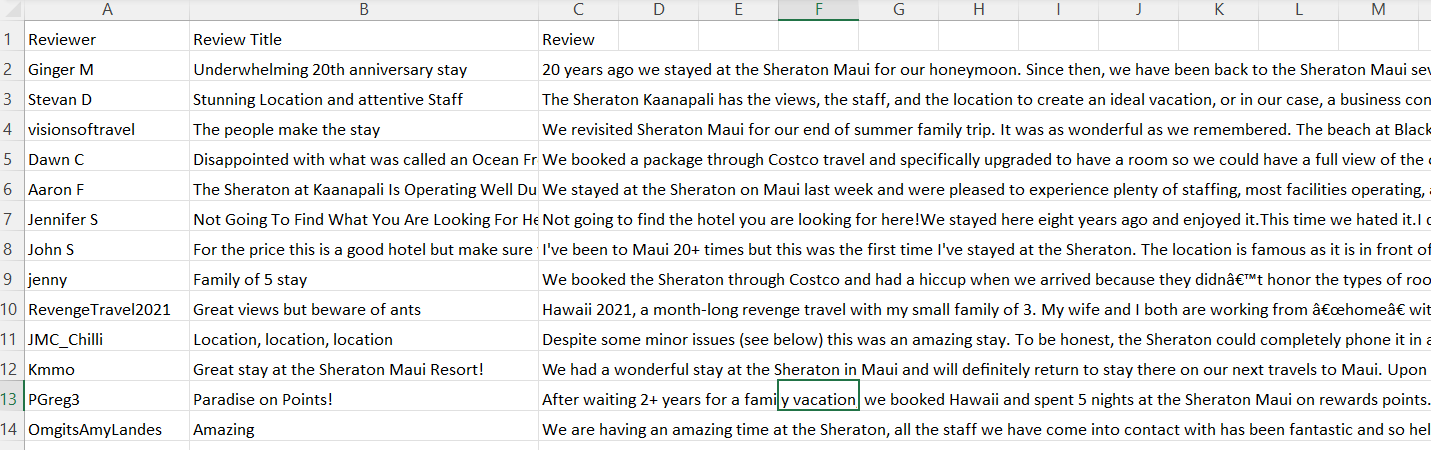

Create a variable containing only the hotel reviews.

In [ ]:
# Create variable containing only the reviews.  
only_reviews = reviews.iloc[:, 2].values

Create a new data frame containing the reviews.

In [ ]:
# Create a new data frame containing only reviews. 
hotel_reviews = pd.DataFrame({'reviews': only_reviews})
hotel_reviews.head(5)

,reviews
0,20 years ago we stayed at the Sheraton Maui fo...
1,"The Sheraton Kaanapali has the views, the staf..."
2,We revisited Sheraton Maui for our end of summ...
3,We booked a package through Costco travel and ...
4,We stayed at the Sheraton on Maui last week an...


**Apply Sentiment Analysis**

Sentiment analysis is a text analysis method that detects polarity (positive or negative opinion) within text. We will use the NLTK (Natural Language Toolkit)  submodule VADER for doing sentiment analysis on the text. 

VADER ( Valence Aware Dictionary for Sentiment Reasoning) is a module used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is applied directly to unlabeled text data and is specifically designed for sentiments expressed in social media.

VADER’s SentimentIntensityAnalyzer() takes in a string and returns a dictionary of scores in each of the following categories:
* negative
* neutral
* positive
* compound (the sum of positive, negative & neutral scores which is then normalized between -1(strongly negative) and +1 (strongly positive).

For example, the following text would return these output  scores:                       
'This was the best, most awesome movie EVER MADE!!!'                       
OUTPUT-{'neg': 0.0, 'neu': 0.425, 'pos': 0.575, 'compound': 0.8877}

The scores range between -1 to 1, with -1 being strongly negative and +1 being strongly positive. We will use the compound score to determine if tweets related to solar energy are positive or negative. 

We will now initialize the Sentiment Intensity Analyzer and create a lambda function that takes in a text string, applies the vader.polarity_scores() function on it to get the results and then return back the compound scores. Using the apply function in Pandas, we can create a new compound column in the data frame with all the compound scores for each tweet.

In [ ]:
# Initialize the SentimentIntensityAnalyzer.
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

# Apply lambda function to get compound scores.
function = lambda title: vader.polarity_scores(title)['compound']
hotel_reviews['compound'] = hotel_reviews['reviews'].apply(function)

In [ ]:
hotel_reviews.head(5)  

,reviews,compound
0,20 years ago we stayed at the Sheraton Maui fo...,0.4127
1,"The Sheraton Kaanapali has the views, the staf...",0.9447
2,We revisited Sheraton Maui for our end of summ...,0.9933
3,We booked a package through Costco travel and ...,0.0000
4,We stayed at the Sheraton on Maui last week an...,0.8879


**Visualize Sentiments**

Let’s see how the sentiments are distributed. We can better understand the common words by plotting word clouds. A word cloud (also known as text clouds) is a visualization where the more a specific word appears in the text, the bigger and bolder it will appear in the word cloud.

Let’s visualize all the words in the data using the word cloud plot.  

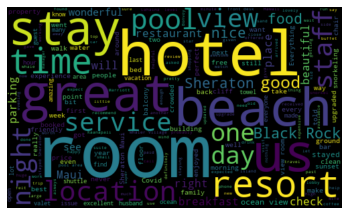

In [ ]:
# Word cloud visualization.
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

allWords = ' '.join([twts for twts in hotel_reviews['reviews']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Room, hotel and beach are common words that stand out.

Create a function to compute the negative (-1), neutral (0), and positive (+1) sentiments, and add a new column named sentiment to our data frame.

In [ ]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) sentiments.
def getAnalysis(score):
 if score < 0:
    return 'Negative'
 elif score == 0:
    return 'Neutral'
 else:
    return 'Positive'

hotel_reviews['sentiment'] = hotel_reviews['compound'].apply(getAnalysis)

# Show the dataframe
hotel_reviews.head(5)

,reviews,compound,sentiment
0,20 years ago we stayed at the Sheraton Maui fo...,0.4127,Positive
1,"The Sheraton Kaanapali has the views, the staf...",0.9447,Positive
2,We revisited Sheraton Maui for our end of summ...,0.9933,Positive
3,We booked a package through Costco travel and ...,0.0000,Neutral
4,We stayed at the Sheraton on Maui last week an...,0.8879,Positive


Let's look at the counts for each sentiment type.  

In [ ]:
# Show the counts for each sentiment.
hotel_reviews['sentiment'].value_counts()

Positive    84
Negative    15
Neutral      1
Name: sentiment, dtype: int64

There are a total of 100 reviews. We see that 84 reviews are positive, 15 are negative and 1 is neutral.

Visualize the counts for each sentiment type.

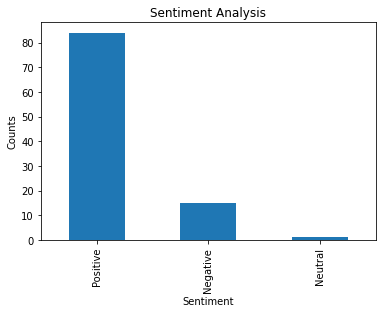

In [ ]:
# Plotting the counts.
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
hotel_reviews['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

Visualize the distribution of sentiments across all reviews.

Text(0, 0.5, 'Hotel Reviews Sentiment')

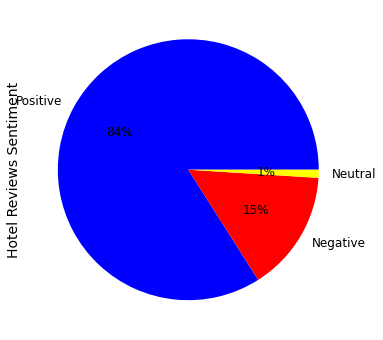

In [ ]:
# Visualize the distribution of sentiment across all reviews.
hotel_reviews.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%',  fontsize=12, figsize=(9,6), colors=["blue", "red", "yellow"])
plt.ylabel("Hotel Reviews Sentiment", size=14)

Visualize sentiments distribution based on compound scores.

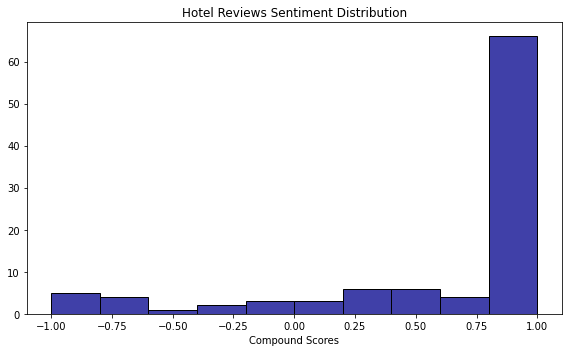

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(hotel_reviews, x='compound', color="darkblue", bins=10, binrange=(-1, 1))
plt.title("Hotel Reviews Sentiment Distribution")
plt.xlabel("Compound Scores")
plt.ylabel("")
plt.tight_layout()

**Conclusions**


There was a total of 100 reviews. The vast majority of reviews show positive sentiments toward this hotel. 84% of sentiments are positive, 15% are negative and 1% are neutral. Based on these results, I think the Sheraton Maui Resort & Spa would be a great place to stay on a vacation.                             